In [1]:
import tensorflow as tf
import os

In [2]:
len(tf.config.list_physical_devices('GPU'))

0

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

In [4]:
import cv2
import imghdr
from matplotlib import pyplot as plt
import numpy as np

C:\Users\logic\AppData\Local\Temp\ipykernel_4552\2123835270.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [5]:
def filter_image_data(data_dir, image_exts):
    for image_class in os.listdir(data_dir):
        for image in os.listdir(os.path.join(data_dir, image_class)):
            image_path = os.path.join(data_dir, image_class, image)
            try:
                image = cv2.imread(image_path)
                tip = imghdr.what(image_path)
                if tip not in image_exts:
                    print('Image not in ext list {}'.format(image_path))
                    os.remove(image_path)
            except Exception as e:
                print('Issue with image {}'.format(image_path))

In [6]:
data_dir = 'images'
image_exts = ['jpeg', 'jpg', 'bmp', 'png'] #For filtering image data
filter_image_data(data_dir, image_exts)

In [7]:
data = tf.keras.utils.image_dataset_from_directory('images')
data_it = data.as_numpy_iterator()

Found 1058 files belonging to 2 classes.


In [8]:
batch = data_it.next()
#Class 0 = cat
#Class 1 = dog

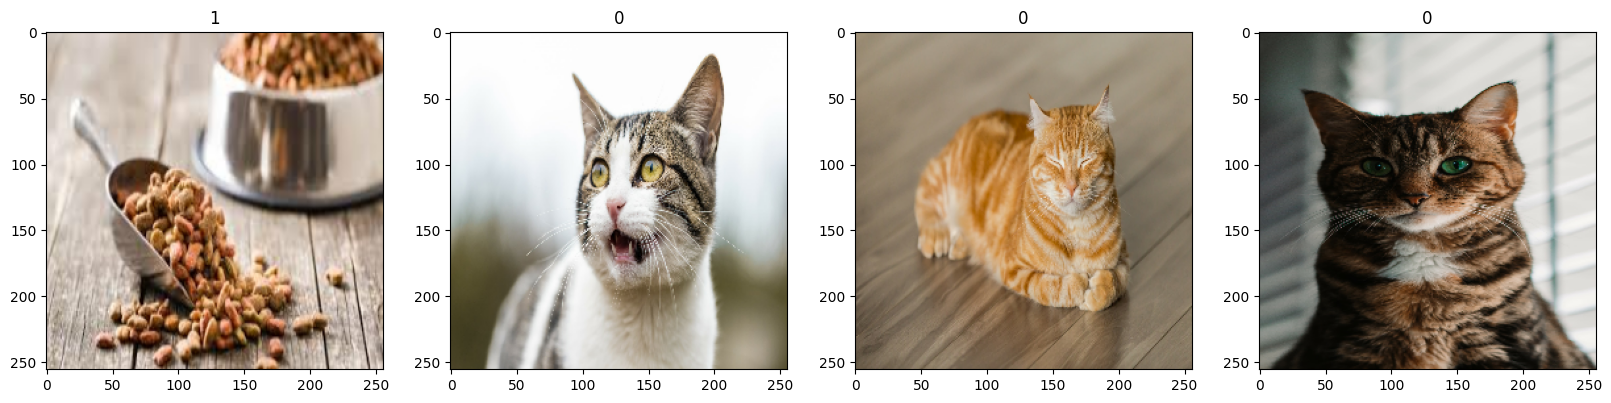

In [9]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [10]:
data = data.map(lambda x,y: (x/255, y))
scaled_it = data.as_numpy_iterator()
batch = scaled_it.next()
batch[0].max()

1.0

In [11]:
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1)

while len(data) < train_size + val_size + test_size:
    train_size -= 1

In [12]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [13]:
from keras import Sequential
from keras import layers

In [14]:
#Creating the model
model = Sequential(
    [
        layers.Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)),
        layers.MaxPool2D(),
        layers.Conv2D(32, (3,3), 1, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, (3,3), 1, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

In [15]:
#Compiling the model
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
# model.summary()

In [16]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [17]:
epochs = 25
hist = model.fit(train, epochs=epochs, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/25
23/23 [==============================] - 13s 447ms/step - loss: 0.7868 - accuracy: 0.5951 - val_loss: 0.6553 - val_accuracy: 0.6719
Epoch 2/25
23/23 [==============================] - 11s 425ms/step - loss: 0.6439 - accuracy: 0.6712 - val_loss: 0.6040 - val_accuracy: 0.7188
Epoch 3/25
23/23 [==============================] - 11s 429ms/step - loss: 0.6327 - accuracy: 0.6685 - val_loss: 0.6291 - val_accuracy: 0.6979
Epoch 4/25
23/23 [==============================] - 11s 430ms/step - loss: 0.6339 - accuracy: 0.6780 - val_loss: 0.6238 - val_accuracy: 0.7240
Epoch 5/25
23/23 [==============================] - 11s 428ms/step - loss: 0.5915 - accuracy: 0.7024 - val_loss: 0.5413 - val_accuracy: 0.7396
Epoch 6/25
23/23 [==============================] - 11s 429ms/step - loss: 0.5653 - accuracy: 0.7147 - val_loss: 0.5016 - val_accuracy: 0.7865
Epoch 7/25
23/23 [==============================] - 11s 432ms/step - loss: 0.5177 - accuracy: 0.7677 - val_loss: 0.4850 - val_accuracy: 0.7448

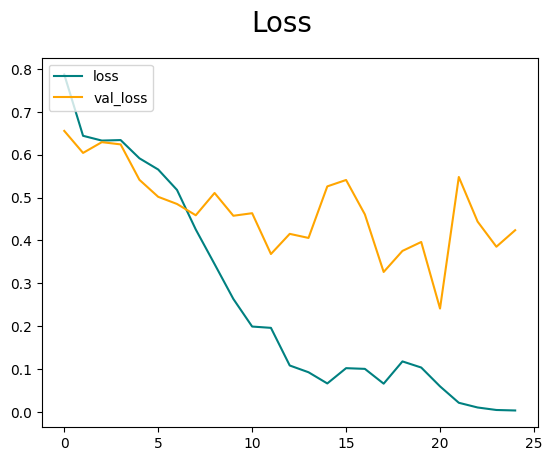

In [18]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

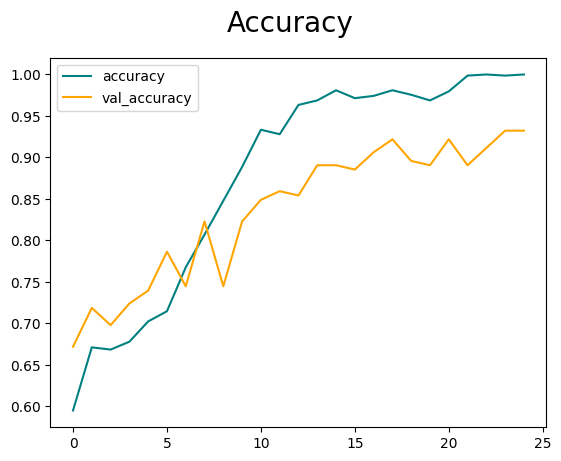

In [19]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [20]:
from keras import metrics

In [21]:
pre = metrics.Precision()
re = metrics.Recall()
acc = metrics.BinaryAccuracy()

In [22]:
for batch in test.as_numpy_iterator():
    X,Y = batch
    yhat = model.predict(X)
    pre.update_state(Y, yhat)
    re.update_state(Y, yhat)
    acc.update_state(Y, yhat)

print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

1/1 [==============================] - 0s 62ms/step
Precision:0.8214285969734192, Recall:0.8214285969734192, Accuracy:0.8958333134651184


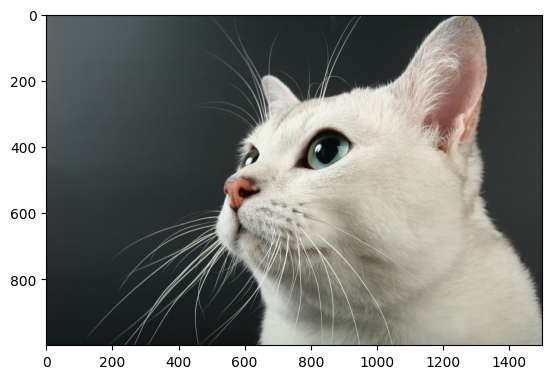

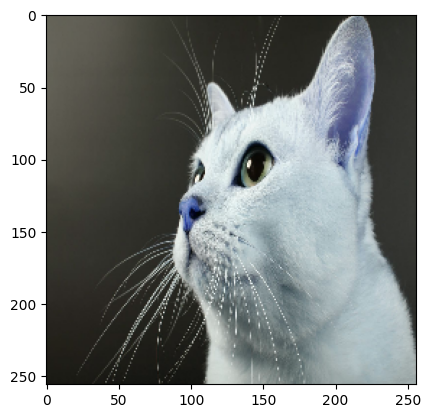

In [23]:
img = cv2.imread('cattest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [24]:
np.expand_dims(resize, 0)
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 41ms/step


In [25]:
if yhat > 0.5:
    print(f'Predicted as a DOG')
else:
    print(f'Predicted as a CAT')

Predicted as a CAT


In [26]:
from keras import models

In [27]:
#Saving the model
model.save(os.path.join('model', 'cat-dog-classify_model.keras'))